<a href="https://colab.research.google.com/github/lukaszplust/NUMERICAL_METHODS/blob/main/Interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import lu_factor, lu_solve
import pdb
import os

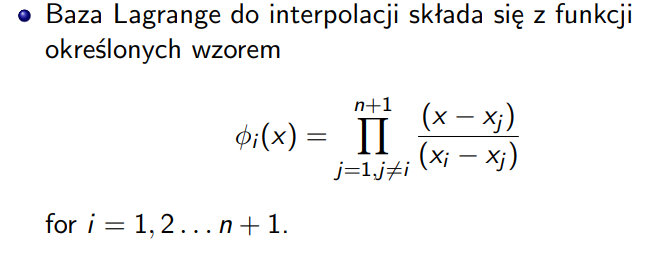

In [2]:
def lagrange_interpolate(point_x,point_y,x):
  value_interpolated = 0
  n = len(point_x)
  for i in range(n):
    fi = 1
    for j in range(n):
      if i != j:
        fi *= (x - point_x[j]) / (point_x[i] - point_x[j]) #tu może jeszcze powinno być 1.0 * przed nawiasem
    value_interpolated += (fi * point_y[i])
  return value_interpolated

In [3]:
def lagrange(value_x, point_x, point_y): #value_distance, nodes_distance, nodes_height
    return [lagrange_interpolate(point_x, point_y, x) for x in value_x]

In [12]:
#x -> wartosc x, dla której chcemy dokonać interpolacji
def spline_interpolate_point(nodes_x, solve, x):
    for i, node_x in enumerate(nodes_x[:-1]):
        next_node_x = nodes_x[i + 1]
        if node_x <= x <= next_node_x:
            h = x - node_x
            interpolated_value = sum(solve[4 * i + j] * h ** j for j in range(4))
            return interpolated_value
    return 0

In [13]:
def spline(value_distance, nodes_distance, nodes_height):
    
    n = len(nodes_distance)# ilość węzłów
    
    matrix_size = 4 * (n-1)

    A, b = np.zeros((matrix_size, matrix_size)), np.zeros(matrix_size)
    #pdb.set_trace()

    for i in range(0, n-1):
      h = nodes_distance[i + 1] - nodes_distance[i]
      #wiersze od 4 * i do 4*i +2 (bez 4 *i +2) oraz kolumny od 4*i do 4*i + 4 (bez 4*i +4) lista [1,0,0,0] odnosi sie do pierwszego wiersza,[1, h, h * h, h * h * h] do drugiego wiersza
      A[4*i:4*i + 2, 4*i:4*i + 4] = [[1, 0, 0, 0], [1, h, h * h, h * h * h]]
      b[4*i:4*i + 2] = [nodes_height[i], nodes_height[i + 1]]

      if i > 0:
        h = nodes_distance[i] - nodes_distance[i - 1]
        A[4*i + 2:4*i + 4, 4*(i-1) + 1:4*(i-1) + 4] = [[1, 2 * h, 3 * h * h], [0, 2, 6 * h]]
        A[4*i + 2:4*i + 4, 4*i + 1:4*i + 3] = [[-1, 0], [0, -2]]


    A[2, 2] = 2
    #3 wiersz, kolumny od 4 * (n - 2) + 2 do 4 * (n - 2) + 4
    A[3, 4 * (n - 2) + 2:4 * (n - 2) + 4] = [2, 6 * (nodes_distance[n - 1] - nodes_distance[n - 2])]

    #pdb.set_trace()
    lu, piv = lu_factor(A)
    solve = lu_solve((lu, piv), b)

    interpolated_values = [spline_interpolate_point(nodes_distance, solve, x) for x in value_distance if nodes_distance[0] <= x <= nodes_distance[-1]]
    interpolated_x = [x for x in value_distance if nodes_distance[0] <= x <= nodes_distance[-1]]

   
    return interpolated_x, interpolated_values

Creating plot for spline method

In [14]:
def spline_plot(value_x, value_y, point_x, point_y, interpolated_x, interpolated_y,name):
    plt.yscale('log')
    plt.plot(value_x, value_y, '-', color = 'blue', label='Próbki')
    plt.plot(interpolated_x, interpolated_y,color = 'green', label='F(x) interpoled')
    plt.plot(point_x, point_y, 'o',color = 'orange' ,label='nodes')

    plt.title(f"{str(name)} Spline_Interpolation for: {str(len(point_x))} nodes")
    plt.xlabel('distance [m]')
    plt.ylabel('height [m.n.p.m]')
    plt.legend()

    save_name = f"{str(name)} Spline_Interpolation for {len(point_x)} nodes.png"
    plt.savefig(save_name)
    plt.show()

Creating plot fot lagrange method

In [15]:
def plot_lagrange(value_x, value_y, point_x, point_y, interpolated_x, interpolated_y,name):
  plt.yscale('log')
  plt.plot(value_x, value_y, '-',color ='blue', label = 'samples')#
  plt.plot(interpolated_x,interpolated_y, color ='green',label = "F(x) interpoled")#funkcja interpolujaca
  plt.plot(point_x, point_y,'o',color ='orange',label = 'nodes')#wezly

  plt.title(f"{str(name)} Lagrange_Interpolation for: {str(len(point_x))} nodes")
  plt.xlabel('distance [m]')
  plt.ylabel('height [m.n.p.m]')
  plt.legend()

  save_name = f"{str(name)} Lagrange_Interpolation for {len(point_x)} nodes.png"
  plt.savefig(save_name)
  plt.show()

Downloading data

In [16]:
#filename = 'MountEverest.csv'
#filename = 'SpacerniakGdansk.csv'
filename = 'Unsyncable_ride.csv'
#filename = 'WielkiKanionKolorado.csv'
df = pd.read_csv(filename)
name = os.path.splitext(os.path.basename(filename))[0]
size = df.shape[0]# len(df.index)

Preparing data

In [17]:
n = 15

intervals = n - 1#to jest ilość odcinków pomiędzy węzłami

x = (size + intervals - 1) // intervals - 1#odstep miedzy wezłami interpolacji

first_node = next(i for i in range(size - 1) if (i + 1) >= (size - 1 - (i + intervals * x)))#pierwszy wezel

nodes_index = [first_node + i * x for i in range(n)]#tablica indeksow wezlow interpolacji

value_distance, value_height = df.iloc[:, 0].tolist(), df.iloc[:, 1].tolist()#odleglosci i wysokosci

nodes_distance = [value_distance[i] for i in nodes_index]#wartosc odleglosci wezłów interpolacji
nodes_height = [value_height[i] for i in nodes_index]#wartosc wysokosci wezłów interpolacji

Wywołanie wcześniej zdefiniowanej funkcji dla Lagrange i wyswietlenie plotu

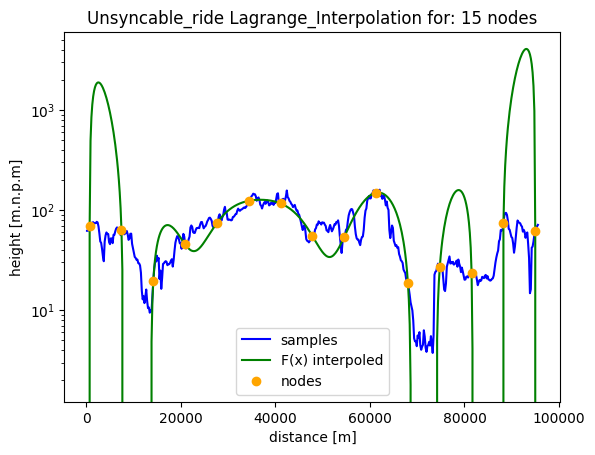

In [18]:
interpolated_lagrange = lagrange(value_distance, nodes_distance, nodes_height)
plot_lagrange(value_distance,value_height,nodes_distance, nodes_height,value_distance,interpolated_lagrange,name)

Wywołanie wcześniej zdefiniowanej funkcji dla Splejnu i wyswietlenie plotu

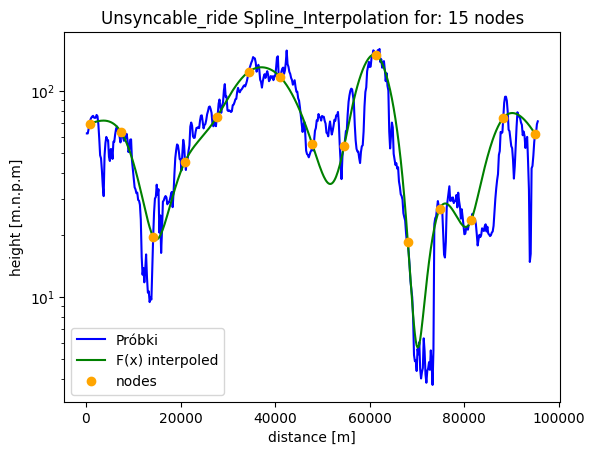

In [19]:
x_for_interpolation, interpolated_values_spline = spline(value_distance, nodes_distance, nodes_height)
spline_plot(value_distance, value_height, nodes_distance, nodes_height, x_for_interpolation, interpolated_values_spline,name)